In [ ]:
# 이번 분석을 위해 GEO 데이터를 사용해야 하니, 해당 데이터를 다루기 위한
# GEOquery라는 패키지와, DEG 분석을 해 주는 limma라는 패키지를 설치해 줍니다.
# 한번 설치하신 후에는 아래 4줄은 지우거나, 앞에 #을 붙여 주석처리 해주셔도 좋습니다.

if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")
BiocManager::install("GEOquery")
BiocManager::install("limma")

In [1]:
# 패키지들을 불러옵니다.
library('GEOquery')
library('limma')

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which.min

Welcome to Bioconductor

    

In [2]:
# 이번 DEG(Differentially Expressed Genes) 분석에 쓸 예제인 GSE3493입니다.
# GEO의 Rectal Cancer 데이터로, 46개의 샘플이 있는 마이크로어레이 데이터입니다.
# 이번에는 방사선 치료에 대해 반응군과 비반응군으로 나누어 상호간 DEG를 분석해 보겠습니다.

gse <- getGEO("GSE3493", GSEMatrix = TRUE)
gse1 <- gse[[1]] # 데이터 테이블이 여러 개(예: miRNA/array 2개 테이블)일 시 각 번호로 매겨지는데,
                # View(gse)를 통해 파일을 직접 확인 후 적절한 데이터를 불러오면 됩니다.
                # 이번에는 array 하나밖에 없으니 첫 번째 항목을 불러옵니다.
                # R은 파이썬과 달리 넘버링할 때 1이 첫 번째를 가리킵니다.


# pData()와 exprs()는 각각 phenotype data, expression data를 가져오는 명령어입니다.
pset <- pData(gse1)
eset <- exprs(gse1)

Found 1 file(s)
GSE3493_series_matrix.txt.gz
Parsed with column specification:
cols(
  .default = col_double(),
  ID_REF = col_character()
)
See spec(...) for full column specifications.
File stored at: 
C:\Users\BIOINF~1\AppData\Local\Temp\RtmpURcGkk/GPL8300.soft


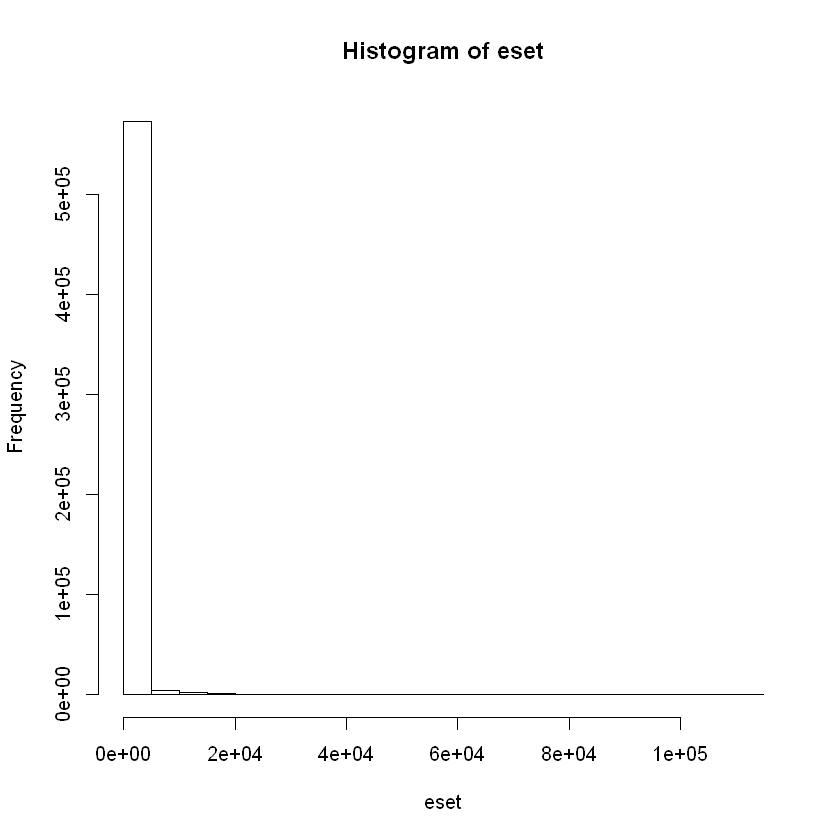

In [3]:
# expression data의 분포를 간단히 확인해 봅니다.
# GSE3493의 경우 상당히 데이터가 쏠려(skewed)있는 것을 확인할 수 있습니다.
hist(eset)

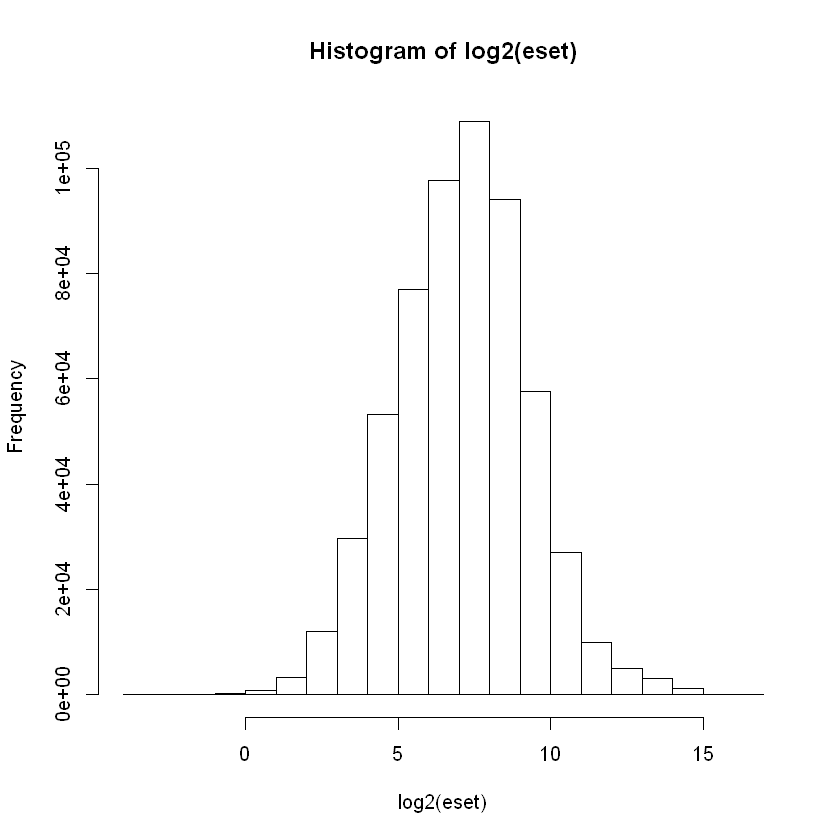

In [4]:
# 이대로 DEG분석을 하면 유전자별 발현량 차이(log Fold Change)가 수십~수백씩 나와 의미를 잃게 됩니다.
# 따라서 log2화시켜, 유전자별 차이가 로그값으로 나타나도록 바꿉니다.
# limma 부분에서 한번 더 설명하겠지만, 결과물에 나타난 logFC는 지수값으로
# 1이면 2배, 2면 4배, 3이면 8배.. 라는 식으로 해석할 수 있게 됩니다.
hist(log2(eset))

In [5]:
# log2화한 분포가 정규성을 나타내므로, log2화한 eset을 새로운 eset으로 지정해 줍니다.
eset <- log2(eset)

In [6]:
# 그러나 문제가 있습니다.
# 이렇게 만든 eset의 index는 각 affymetrix array의 probe명으로 지정되어 있습니다.
# 데이터를 확인해봅시다. head()는 데이터의 첫 row 5개를 보여줍니다.
head(eset)

,GSM79068,GSM79069,GSM79070,GSM79071,GSM79072,GSM79073,GSM79074,GSM79075,GSM79076,GSM79077,...,GSM79104,GSM79105,GSM79106,GSM79107,GSM79108,GSM79109,GSM79110,GSM79111,GSM79112,GSM79113
1000_at,9.612500,10.216503,10.505117,9.788392,10.634993,10.538868,10.435358,10.693922,10.645478,10.641600,...,10.369815,10.544482,10.257034,10.182891,9.819540,10.819061,10.748361,10.456662,10.873752,10.852686
1001_at,5.620586,6.578939,6.671010,5.575917,8.211402,6.886306,7.108524,7.142618,7.179909,5.364572,...,6.963474,4.727920,7.075747,6.493455,6.076816,7.624247,8.080551,6.400879,7.778077,8.193279
1002_f_at,3.925999,4.095924,5.325530,5.623516,6.491853,5.768184,6.626439,7.422065,5.569856,5.274262,...,6.083213,5.259272,5.061776,3.944858,5.504620,6.332708,6.752213,5.392317,4.827819,5.560715
1003_s_at,6.956521,6.723832,7.938403,7.517276,8.561097,7.196725,6.542258,7.976707,7.815704,7.086402,...,7.152792,8.346957,6.797013,7.115824,5.958843,8.561097,8.436712,8.085340,7.257388,8.043301
1004_at,6.464342,5.381975,7.589464,7.884476,8.610287,8.008429,8.193772,8.747857,6.274262,8.223519,...,7.938991,7.695576,7.610287,7.948367,7.074677,7.995485,9.374822,8.759222,9.023200,8.663202
1005_at,8.413205,9.500045,7.931328,10.512444,8.287251,6.414474,7.633722,5.974988,8.138016,8.832574,...,9.782507,9.184875,8.653562,8.108524,8.036723,8.312883,9.395534,9.086667,8.839519,9.802193


In [7]:
# 이대로는 각 probe가 어떤 유전자인지 모르니, Gene symbol로 바꾸어 줍시다.
# fData()는 feature data를 보여주는 명령어입니다. 내용을 확인해 봅시다.
fset <- fData(gse1)
colnames(fset)

[1] "ID"                               "GB_ACC"                          
 [3] "SPOT_ID"                          "Species Scientific Name"         
 [5] "Annotation Date"                  "Sequence Type"                   
 [7] "Sequence Source"                  "Target Description"              
 [9] "Representative Public ID"         "Gene Title"                      
[11] "Gene Symbol"                      "ENTREZ_GENE_ID"                  
[13] "RefSeq Transcript ID"             "Gene Ontology Biological Process"
[15] "Gene Ontology Cellular Component" "Gene Ontology Molecular Function"

In [8]:
# Gene Symbol이라는 column이 있는 것을 확인할 수 있습니다. 내용을 확인해 봅시다.
head(fset$'Gene Symbol')
# 각 probe별 유전자가 적혀 있습니다. 이 순서는 expression data의 index와 같습니다.

[1] "MAPK3"   "TIE1"    "CYP2C19" "CXCR5"   "CXCR5"   "DUSP1"

In [9]:
symbols <- fset[,"Gene Symbol"]   # 이후 해당 칼럼의 내부 데이터만을 symbols라는 변수로 지정해 주고,
rownames(eset) <- symbols         # eset의 rownames를 symbols로 바꿔 줍니다.
head(eset)                        # index가 유전자명으로 잘 바뀐 것을 확인할 수 있습니다.

,GSM79068,GSM79069,GSM79070,GSM79071,GSM79072,GSM79073,GSM79074,GSM79075,GSM79076,GSM79077,...,GSM79104,GSM79105,GSM79106,GSM79107,GSM79108,GSM79109,GSM79110,GSM79111,GSM79112,GSM79113
MAPK3,9.612500,10.216503,10.505117,9.788392,10.634993,10.538868,10.435358,10.693922,10.645478,10.641600,...,10.369815,10.544482,10.257034,10.182891,9.819540,10.819061,10.748361,10.456662,10.873752,10.852686
TIE1,5.620586,6.578939,6.671010,5.575917,8.211402,6.886306,7.108524,7.142618,7.179909,5.364572,...,6.963474,4.727920,7.075747,6.493455,6.076816,7.624247,8.080551,6.400879,7.778077,8.193279
CYP2C19,3.925999,4.095924,5.325530,5.623516,6.491853,5.768184,6.626439,7.422065,5.569856,5.274262,...,6.083213,5.259272,5.061776,3.944858,5.504620,6.332708,6.752213,5.392317,4.827819,5.560715
CXCR5,6.956521,6.723832,7.938403,7.517276,8.561097,7.196725,6.542258,7.976707,7.815704,7.086402,...,7.152792,8.346957,6.797013,7.115824,5.958843,8.561097,8.436712,8.085340,7.257388,8.043301
CXCR5,6.464342,5.381975,7.589464,7.884476,8.610287,8.008429,8.193772,8.747857,6.274262,8.223519,...,7.938991,7.695576,7.610287,7.948367,7.074677,7.995485,9.374822,8.759222,9.023200,8.663202
DUSP1,8.413205,9.500045,7.931328,10.512444,8.287251,6.414474,7.633722,5.974988,8.138016,8.832574,...,9.782507,9.184875,8.653562,8.108524,8.036723,8.312883,9.395534,9.086667,8.839519,9.802193


In [10]:
# 이제 반응군/비반응군을 구분짓기 위해, '디자인 매트릭스' 라는 것을 만들어 줍니다.
# 이는 limma에서 각 군을 나누는 기준을 인식하기 위한 표준으로써 필요한 과정입니다.
# 우선 pset에서 반응군/비반응군이 적힌 'description'이라는 칼럼을 확인해 보겠습니다.
head(pset$'description')

[1] training-responder training-responder training-responder training-responder
[5] training-responder test-responder    
4 Levels: test-non-responder test-responder ... training-responder

In [11]:
# 여기에는 총 4개의 factor가 있습니다. 각각 training/test, responder/non-responder입니다.
# 저희는 training과 test를 구분지을 필요는 없으니, non-responder와 responder만 구분짓겠습니다.
# 우선 빈 46개의 리스트를 만들어 줍니다.

response <- rep(1:46)

# 그리고 grep이라는 명령어를 사용해, 'non'이라는 문자를 포함했는지 여부에 따라
# 'non-res', 'res'라는 표지를 하여 해당 리스트에 순서에 맞춰 지정해 줍니다.
# 이 리스트를 pset의 description에 새로 지정해 줍니다.

response <- replace(response,grep('non',pset[['description']]),'non-res')
response <- replace(response,c(1:46)[-grep('non',pset[['description']])],'res')
pset$description <- response

In [12]:
# 이제 디자인 매트릭스를 만들 차례입니다.
# eset의 샘플 수와 우리가 만든 pset의 description의 수가 같아야 하므로,
# eset의 column count와 pset의 row count가 같은지 확인해 봅니다.
# dim()은 matrix의 각 행,열의 길이를 알려 주는 명령어입니다.
dim(eset)
dim(pset)

[1] 12625    46

[1] 46 32

In [13]:
# model.matrix는 디자인 매트릭스를 만드는 명령어입니다.
# 앞서 새로 지정한 pset의 description 데이터를 통해 디자인 매트릭스를 작성합니다.
design <- model.matrix(~0+pset$description)
head(design)

,pset$descriptionnon-res,pset$descriptionres
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1


In [14]:
# 칼럼명이 지저분하니, 알아보기 쉽게 지정해 줍시다.
colnames(design) <- c('non_res','res')
head(design)

,non_res,res
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1


In [15]:
# 이제 본격적인 DEG 분석의 시작입니다. 매우 간단합니다.
# 우선 eset과 아까 만들었던 디자인 매트릭스로 linear model fit을 만들어 줍니다.
fit = lmFit(eset,design)

# 이후 makeContrasts() 명령어로 어떤 집단이 대조군인지 설정해 줍니다.
# diff=(2그룹)-(1그룹)으로 설정하면, 1그룹에 대한 2그룹의 차이를 나타내 줍니다.
# 즉 2그룹이 1그룹보다 2배 발현량이 높다면 결과값으로 logFC = 1 을 출력하고,
# 0.5배로 낮다면 logFC = -1 을 출력하겠죠?
# control 그룹을 1그룹으로 두는 것을 추천합니다.
cont <- makeContrasts(diff=res-non_res,levels=design)

# contrasts.fit() 명령어로 linear model fit과 contrasts matrix를 넣어 분석합니다.
# 이 명령어는 상관계수와 표준오차를 계산해 줍니다.
fit.cont <- contrasts.fit(fit,cont)

# 이후 Bayes statistics를 이용해 DEG 분석을 시행합니다.
fit.cont <- eBayes(fit.cont)

# topTable이라는 명령어를 이용해 알기 쉬운 table 형식의 데이터로 결과를 정리합니다.
res <- topTable(fit.cont,number=Inf)

# 결과를 확인하고, 원하는 파일명으로 저장해 줍니다.
head(res)
write.table(res,file='GSE3493_DEG.txt',sep='\t',quote = FALSE,row.names = FALSE)

,ID,logFC,AveExpr,t,P.Value,adj.P.Val,B
4106,SSX1,-0.8444656,6.499623,-4.481892,4.513502e-05,0.2929913,-3.441906
3028,HAVCR1,1.6524184,3.895036,4.473445,4.641446e-05,0.2929913,-3.445310
5930,PAFAH2,-0.7030902,6.910766,-3.654879,6.311869e-04,0.9995301,-3.775036
3215,WHAMMP2 /// WHAMMP3,-1.3404127,5.931969,-3.509801,9.785414e-04,0.9995301,-3.832606
3639,NKX2-2,0.8137630,4.853347,3.327915,1.675017e-03,0.9995301,-3.903942
8632,L1CAM,0.9431848,6.066182,3.303597,1.797884e-03,0.9995301,-3.913395
